In [16]:
using Integrals
using Plots

In [17]:
function get_data(filename)
    data = Float64[]
    io = open(filename)
    while !eof(io)
        line = readline(io)
        line_split = split(line, ',')
        data_points = parse.(Float64, line_split)
        append!(data, data_points)
    end
    close(io)
    reshape(data, 2, :)'
end;

In [18]:
# Polynomial basis.
function Ψₘ(m, K, r, θ)
    (a/r)^2m * (sin(2m*θ) + K*r/(2m-1) * sin((2m-1)*θ))
end

function Φₘ(m, K, r, θ)
    (a/r)^2m * (cos(2m*θ) + K*r/(2m-1) * cos((2m-1)*θ))
end;

In [19]:
function Ψc(K, r, θ)
    π * exp(-K*r*cos(θ)) * sin(K*r*sin(θ))
end

function Φc(K, r, θ)
    π * exp(-K*r*cos(θ)) * cos(K*r*sin(θ))
end;

In [20]:
function Ψs(K, r, θ)
    function h(k, p)
        exp(-k*r*sin(θ)) / (K^2 + k^2) * (k * sin(k*r*cos(θ)) + K * cos(k*r*cos(θ)))
    end
    Iprob = IntegralProblem(h, (0, Inf))
    I = solve(Iprob, QuadGKJL()).u
    I - π * exp(-K*r*cos(θ)) * cos(K*r*sin(θ))
end

function Φs(K, r, θ)
    function h(k, p)
        exp(-k*r*sin(θ)) / (K^2 + k^2) * (k * cos(k*r*cos(θ)) - K * sin(k*r*cos(θ)))
    end
    Iprob = IntegralProblem(h, (0, Inf))
    I = solve(Iprob, QuadGKJL()).u
    -I + π * exp(-K*r*cos(θ)) * sin(K*r*sin(θ))
end;

In [21]:
# Solutions in time domain.
function ψ⃰(t, K, r, θ, p, q)
    σ = sqrt(K/g)
    ps = Ψc(K, r, θ)*cos(σ*t) + Ψs(K, r, θ)*sin(σ*t)
    for m in 1:N
        ps += (cos(σ*t) * p[m] + sin(σ*t) * q[m]) * Ψₘ(m, K, r, θ)
    end
    ps
end

function ϕ⃰(t, K, r, θ, p, q)
    σ = sqrt(K/g)
    ps = Φc(K, r, θ)*cos(σ*t) + Φs(K, r, θ)*sin(σ*t)
    for m in 1:N
        ps += (cos(σ*t) * p[m] + sin(σ*t) * q[m]) * Φₘ(m, K, r, θ)
    end
    ps
end;

In [22]:
function get_coefficients_pq(K)
    c = zeros(length(θ_values))
    s = zeros(length(θ_values))
    F = zeros(length(θ_values), N)
    for (i, θ) in enumerate(θ_values)
        c[i] = Ψc(K, a, θ) - Ψc(K, a, π/2) * sin(θ)
        s[i] = Ψs(K, a, θ) - Ψs(K, a, π/2) * sin(θ)
        for (j, m) in enumerate(1:N)
            F[i, j] = -sin(2m*θ) - K*a/(2m-1) * (sin((2m-1)*θ) - sin(θ) * sin((2m-1)*π/2))
        end
    end
    p = F \ c
    q = F \ s
    return p, q
end;

In [23]:
function get_coefficients_AB(K, p, q)
    A = Ψc(K, a, π/2)
    B = Ψs(K, a, π/2)
    for m in 1:length(p)
        Tm = (-1)^(m-1) * K*a / (2m-1)
        A += Tm * p[m]
        B += Tm * q[m]
    end
    return A, B
end;

In [24]:
function get_coefficients_MN(K, p, q)
    function fM(θ, p)
        Φs(K, a, θ) * cos(θ)
    end
    function fN(θ, p)
        Φc(K, a, θ) * cos(θ)
    end
    IMprob = IntegralProblem(fM, (0, π/2))
    INprob = IntegralProblem(fN, (0, π/2))
    IM = solve(IMprob, QuadGKJL()).u
    IN = solve(INprob, QuadGKJL()).u

    M = IM + π*K*a/4 * q[1]
    N = IN + π*K*a/4 * p[1]
    for m in 1:length(p)
        Tm = (-1)^(m-1) / (4m^2-1)
        M += Tm * q[m]
        N += Tm * p[m]
    end
    return M, N
end;

In [25]:
function get_rao_and_radiation_coefficients(K)
    σ = sqrt(K*g)
    p, q = get_coefficients_pq(K)
    A, B = get_coefficients_AB(K, p, q)
    M, N = get_coefficients_MN(K, p, q)
    RAO = π*K*a / sqrt(A^2 + B^2)
    Am = 4/π * (M*B + N*A) / (A^2 + B^2)
    Bm = 4σ/π * sqrt(a/g) * (M*A - N*B) / (A^2 + B^2)
    return RAO, Am, Bm
end;

In [26]:
a = 1.0
g = 9.81
N = 6
K_values = collect(0.03:0.01:4.0)
θ_values = π/180 * collect(0:10:90)
σ_values = sqrt.(g * K_values)
ω_values = sqrt(a/g) * σ_values;  # Dimensionless frequencies.

# Experimental results by J. H. Vugts.
rao_vugts = get_data("rao_vugts.csv")
azz_vugts = get_data("azz_vugts.csv")
bzz_vugts = get_data("bzz_vugts.csv");

In [27]:
RAO_values = zeros(length(K_values))
Am_values = zeros(length(K_values))
Bm_values = zeros(length(K_values))
for (i, K) in enumerate(K_values)
    RAO, Am, Bm = get_rao_and_radiation_coefficients(K)
    RAO_values[i] = RAO
    Am_values[i] = Am
    Bm_values[i] = Bm
end;

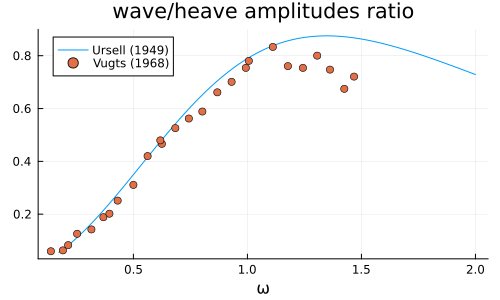

In [28]:
plot(ω_values, RAO_values, label="Ursell (1949)", size=(500, 300))
plot!(rao_vugts[:, 1], rao_vugts[:, 2], label="Vugts (1968)", markershape=:circle, seriestype=:scatter)
title!("wave/heave amplitudes ratio")
xlabel!("ω")
# savefig("rao.svg")

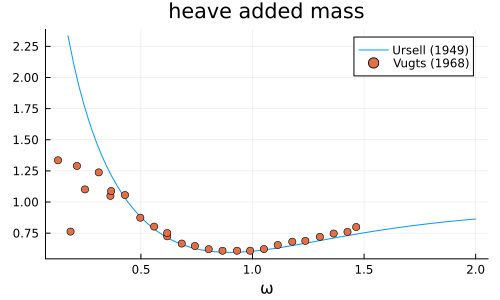

In [29]:
plot(ω_values, Am_values, label="Ursell (1949)", size=(500, 300))
plot!(azz_vugts[:, 1], azz_vugts[:, 2], label="Vugts (1968)", markershape=:circle, seriestype=:scatter)
title!("heave added mass")
xlabel!("ω")
# savefig("azz.svg")

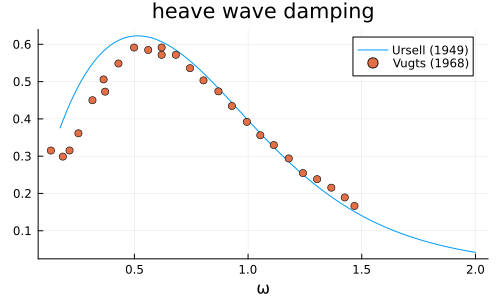

In [30]:
plot(ω_values, Bm_values, label="Ursell (1949)", size=(500, 300))
plot!(bzz_vugts[:, 1], bzz_vugts[:, 2], label="Vugts (1968)", markershape=:circle, seriestype=:scatter)
title!("heave wave damping")
xlabel!("ω")
# savefig("bzz.svg")